# Predicting Unstructured Data Using Convolutional Neural Networks (CNN) and Random Forests (RF)
This is a small demonstration of two Machine Learning Models to compare its predictive power in an unstructured dataset (numerical images from the sikit learn library). This Jupyter Notebook is available for download, the code includes the import of the relevant dataset. The models will be resolving the same problem with the same dataset. Data Analysis of the results will be presented in the Looker Studio section. Be mindful of the considerations of the model specified at the end of the Notebook before extrapolating these results.

# Getting the data

We import load_digits from sklearn, the object that contains the digits dataset, as well as all other libraries that are required for this anlaysis

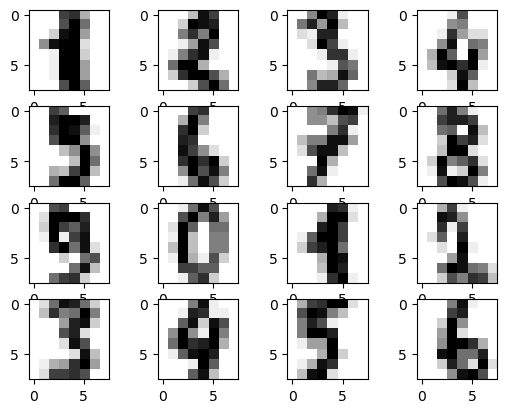

In [4]:
from sklearn.datasets import load_digits
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset



digits = load_digits()

for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(digits.images[i,:,:], cmap=plt.get_cmap('gray_r'))


We transform it into a Pandas DataFrame to utilize it for Random Forests later

In [6]:
digits_df = pd.DataFrame(data=digits.data, columns=digits.feature_names)

digits_df['target'] = digits.target

digits_df.head()


,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


As it is a DataFrame, we can group to see the data distribution of the model

In [8]:
target_counts = digits_df['target'].value_counts()
target_counts_df = target_counts.reset_index()
target_counts_df.columns = ['number', 'amount']

We have an evenly distributed, albeit small, dataset with which to train our supervised learning models

# Spliting the data
The data will be split into two sub datasets, one for training, one for testing. Proportions will be 80% and 20% respectively. Do note that it is preferable to do feature engineering to save some time before doing the split (except for the validation set which should be kept separated at all times), but since im not doing feature engineering in this small example we will procede with this step right away. Predictions in the test sets will be compared later between the two models. As there is no engineering, there will also not be a validation set.

#### Dataframe for Random Forests

In [12]:
df_train, df_test = train_test_split(digits_df, test_size=0.2, random_state=42)
print('Values in each Dataframe')
print('train: ', str(df_train.shape[0]))
print('test: ', str(df_test.shape[0]))

Values in each Dataframe
train:  1437
test:  360


#### Dataset for CNN

In [14]:
class ImageDataset(Dataset):
    def __init__(self, df):

        self.df = df
        self.pixel_columns = [f'pixel_{i}_{j}' for i in range(8) for j in range(8)]  # 8x8 pixels
        self.target_column = 'target'
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        image = self.df.iloc[idx][self.pixel_columns].values 
        target = self.df.iloc[idx][self.target_column]  
        
        image = image.reshape(1, 8, 8) 
        
        image = torch.tensor(image, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.long) 
        
        return image, target

CNN_train = ImageDataset(df_train)
CNN_test = ImageDataset(df_test)

# Definiton and training of the CNN

This CNN will have two convolutional layers with max pooling applied to its outputs, and two fully conected layers

In [32]:
class NetCNN(nn.Module):
    def __init__(self):

        #Convolutional Layers
        super(NetCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1)

        #Fully Connected Layers
        self.fc1 = nn.Linear(16 * 2 * 2, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2)  # Output: (6, 4, 4)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2)  # Output: (16, 2, 2)
        
        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 16 * 2 * 2)  # Flatten: 16 channels * 2x2 feature map size
        
        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output: 10 classes
        
        return x

Training the CNN Model

In [49]:
learning_rate = 0.0001
device = torch.device('cpu')
net = NetCNN()
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

#Cross entropy to be used as Loss Function
criterion = torch.nn.CrossEntropyLoss()
loader = DataLoader(dataset=CNN_train, batch_size=20, shuffle=True)
num_epochs = 20

# Defining the forward and backward process
for i in range(num_epochs):
    for x, y in loader:
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        loss = criterion(net(x), y)
        loss.backward()
        optimizer.step()
        
torch.save(net.state_dict(), "./cnn20.pth")

In [51]:
net = NetCNN()
net.load_state_dict(torch.load("./cnn20.pth"))
net.to(device)

loader_test = DataLoader(dataset=CNN_test, batch_size=10000, shuffle=False)
x_test = list(loader_test)[0][0]
y_test = list(loader_test)[0][1]

x_test = x_test.to(device)

pred = net(x_test)

pred_y = torch.max(pred.to("cpu"), 1)[1].data.numpy()

print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      0.82      0.90        28
           2       0.89      1.00      0.94        33
           3       0.97      1.00      0.99        34
           4       0.98      1.00      0.99        46
           5       0.98      0.94      0.96        47
           6       0.97      1.00      0.99        35
           7       0.94      0.97      0.96        34
           8       0.88      0.97      0.92        30
           9       0.94      0.85      0.89        40

    accuracy                           0.96       360
   macro avg       0.96      0.95      0.95       360
weighted avg       0.96      0.96      0.95       360



C:\Users\bmala\AppData\Local\Temp\ipykernel_12208\1693141818.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("./cnn20.pth"))
